# Sheet 6: Solution

In [5]:
options(jupyter.plot_mimetypes = 'image/png',repr.plot.width=4,repr.plot.height=4) # this is just to render graphics as png and not as svg, and to adjust the default size

Whereas in exercise 3 on sheet 3, we used linear regression of an indicator matrix for classification, on this sheet, we will use logistic regression and Gaussian discriminant analysis for classification. These are widely used standard approaches for classification, whereas linear regression of an indicator matrix is an approach fraud with problems. See e.g. the problem of "masking classes" discussed in Hastie et al. (2009), section 4.2., or the problem of the assumption of the linear model for the conditional probability $Pr(G = k|X = x)=E(Y_k|X = x)$ (where $Y_k$ is 1 if $G=k$ is a component of the response vector $Y$), which allows negative values and values greater than 1 for the conditional probability.

## Exercise 1

Maximize the likelihood. You can define $\theta_i =                          
\text{sigm}(x_i^T \beta)$ for this. Why can the resulting equations
not be solved in closed form for the parameters $\beta$ (as in
linear regression), but are suitable for iterative methods?
  
\begin{align}
l(\beta) 
& = \sum_{i=1}^N \log \left(\theta_i^{\mathbb{I}(g_i=1)}(1-\theta_i)^{\mathbb{I}(g_i=0)} \right) \\
& = \sum_{i=1}^N g_i \log \theta_i + (1-g_i) \log (1-\theta_i) 
\end{align}

Maximize, using $\frac{d}{d\beta_n} \log \theta_i = (1-\theta_i) x_{in}$ and $\frac{d}{d\beta_n}\log(1-\theta_i) = -\theta_i x_{in}$

\begin{align}
\frac{d}{d\beta_n} l(\beta) = \sum_i (g_i-\theta_i) x_{in} = \pmb{X}^T (\pmb{g} - \pmb{\theta})
\end{align}

Evidently solving $\frac{d}{d\beta_n} l(\beta) = 0$ for $\beta$ is not possible in closed form. The Hessian (obtained as $H_{nm} = \frac{d}{d\beta_n} \frac{d}{d\beta_m} l(\beta)$), which is given on the sheet though
$$
\pmb{H} = - \sum_i \theta_i (1-\theta_i) x_i x_i^T
$$
is negative definite. To show this, consider multiplying with a vector $u\in \mathbb{R}^{p+1}$ from left and the right

$$
u^T \pmb{H} u = - \sum_i \theta_i (1-\theta_i) (x_i^T u)^2 \leq 0
$$

As $\theta_i \in (0,1)$ equality only holds if $u=0$ or if $u$ is in the null space (kernel) of $\pmb{X}$, that is perpendicular to all vectors $x_i$. It is extremely unlikely that such a vector exists in $\mathbb{R}^{p+1}$ as soon as $N \gg p + 1$. Then $\pmb{H}$ is strictly negative definite, $l(\beta)$ therefore concave, and $-l(\beta)$ therefore convex with a unique minimum that can easily be found with standard iterative search algorithms (Newton-Raphson, BFGS). 


## Exercise 2

Read the SAheart data from website

In [11]:
library(ElemStatLearn)
data(SAheart)

In [93]:
head(SAheart)
names(SAheart)[1]
length(SAheart$chd)
length(SAheart[,2])

sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd,null
160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1,0
144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1,0
118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0,0
170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1,0
134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1,0
132,6.20,6.47,36.21,Present,62,30.77,14.14,45,0,0


[1] "sbp"

[1] 462

[1] 462

Again: there seems to be a high dependence of balance and default, but almost no dependence of income and default.

Let us a fit a logistic regression model to this. First let us do this univariate, using only the variable "student".

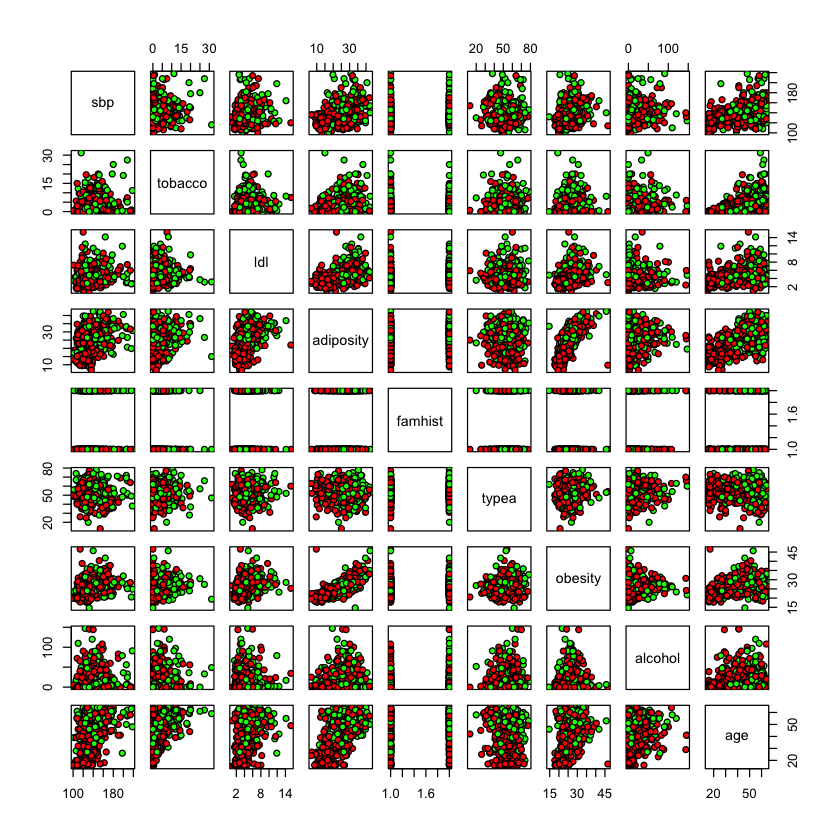

In [14]:
# Pretty plot
pairs(SAheart[1:9],pch=21,bg=c("red","green")[factor(SAheart$chd)])

In [77]:
# Logistic regression of null model 
SAheart$null <- 0
head(SAheart)

logit_null <- glm(chd ~ null, data=SAheart, family=binomial)
summary(logit_null)
loglik_null <- logLik(logit_null)
print(loglik_null)

sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd,null
160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1,0
144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1,0
118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0,0
170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1,0
134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1,0
132,6.20,6.47,36.21,Present,62,30.77,14.14,45,0,0



Call:
glm(formula = chd ~ null, family = binomial, data = SAheart)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9221  -0.9221  -0.9221   1.4563   1.4563  

Coefficients: (1 not defined because of singularities)
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.63525    0.09778  -6.497 8.21e-11 ***
null              NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 596.11  on 461  degrees of freedom
Residual deviance: 596.11  on 461  degrees of freedom
AIC: 598.11

Number of Fisher Scoring iterations: 4


'log Lik.' -298.0542 (df=1)


The positive coefficient tells us that students tend to have a higher default probability than non-students. Now let us use all available information in a multivariate logistic regression.

In [1]:
library(specfun)
help(sp.gammainc)
sp.gammainc(0.5,-2*(-298+289))$gip
# Likelihood_ratio-test
loglik_ratio_test <- function(LLF_full,LLF_reduced,df) 1-sp.gammainc(df/2,-2*(LLF_reduced-LLF_full)/2)$gip


[1] 1

In [116]:
# Logistic regression of one feature model and compared to null model
loglik_single <- array(0,c(9))
loglik_ratio <- array(0,c(9))
fmla <- as.formula(paste("chd ~ ", paste(names(SAheart)[i], collapse= "+")))
print(fmla)
for(i in 1:9){
    logit_single <- glm(fmla <- as.formula(paste("chd ~ ", paste(names(SAheart)[i], collapse= "+"))),data=SAheart, family=binomial)
    loglik_single[i] <- logLik(logit_single)
    loglik_ratio[i] <- loglik_ratio_test(loglik_single[i],loglik_null,1)  
}
print(loglik_single)
print(loglik_ratio)

chd ~ chd
[1] -289.6612 -277.3237 -282.1394 -282.5257 -280.9472 -295.5623 -295.7642
[8] -297.1727 -262.7812
[1] 4.183864e-05 1.202478e-10 1.683083e-08 2.505507e-08 4.937093e-09
[6] 2.558691e-02 3.234610e-02 1.842540e-01 0.000000e+00


In [217]:
# feature selection by adding one additional feature at one time
feature_sidx <- order(loglik_ratio)
print("The important of features:\n")
print(names(SAheart)[feature_sidx])
# i = 1
feature_curridx <- feature_sidx[1]
logit_curr <- glm(fmla <- as.formula(paste("chd ~ ", paste(names(SAheart)[feature_curridx], collapse= "+"))),data=SAheart, family=binomial)
loglik_curr <- logLik(logit_curr)
for(i in 2:9){
    feature_nexidx <- unique(c(feature_curridx,feature_sidx[i]))
    logit_mf <- glm(fmla <- as.formula(paste("chd ~ ", paste(names(SAheart)[feature_nexidx], collapse= "+"))),data=SAheart, family=binomial)
    loglik_mf <- logLik(logit_mf)
    loglik_mf_ratio <- loglik_ratio_test(loglik_mf,loglik_curr,1)
    if (loglik_mf_ratio < 0.05){
        loglik_curr <- loglik_mf
        feature_curridx <- feature_nexidx
    }
    }

# print selected features and their coefficients      
print("Likelyhood selected features:\n")
print(coef(logit_mf)[1:length(feature_curridx)+1])


[1] "The important of features:\n"
[1] "age"       "tobacco"   "famhist"   "ldl"       "adiposity" "sbp"      
[7] "typea"     "obesity"   "alcohol"  
[1] "Likelyhood selected features:\n"
           age        tobacco famhistPresent            ldl          typea 
    0.05057203     0.07945512     0.90511148     0.16285613     0.03706552 


Compute the false positive rate and the true positive rate for the decision level 0.5.

In [191]:
# feature selection by L1 regression

### Centering and scaling
SAheartScaled <- SAheart[,1:9]
SAheartScaled$famhist <- as.numeric(SAheart$famhist)

xbar <- colMeans(SAheartScaled)
vbar <- colSums(scale(SAheartScaled, center = xbar, scale = FALSE)^2)/(dim(SAheart)[1]-1)
SAheartScaled <- as.data.frame(scale(SAheartScaled, 
                        center = xbar, 
                        scale = c(sqrt(vbar))))


SAheartScaled$chd <- SAheart$chd
head(SAheartScaled)
colMeans(SAheartScaled)

sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
1.0574173,1.8210988,0.4778941,-0.2951832,1.1845700,-0.4180170,-0.17659445,3.2741887,0.6286543,1
0.2767892,-0.7893817,-0.1595071,0.4116942,-0.8423609,0.1931344,0.67064592,-0.6120811,1.3816170,1
-0.9917313,-0.7741412,-0.6085852,0.8833742,1.1845700,-0.1124413,0.73472292,-0.5405973,0.2179473,0
1.5453098,0.8413521,0.8062523,1.6223824,1.1845700,-0.2142999,1.41109128,0.2947424,1.0393612,1
-0.2111033,2.1694532,-0.5989276,0.3050200,1.1845700,0.7024273,-0.01284211,1.6459912,0.4233008,1
-0.3086818,0.5583142,0.8352251,1.3884702,1.1845700,0.9061444,1.12155816,-0.1186384,0.1494961,0


sbp       tobacco           ldl     adiposity       famhist 
-1.542026e-16 -3.793863e-17 -8.422045e-17  1.873276e-16  1.831147e-16 
        typea       obesity       alcohol           age           chd 
-7.123255e-17 -2.408863e-16  5.614571e-17  1.255609e-17  3.463203e-01

In [190]:
library(glmnet)
logit_l1 <- glmnet(x = as.matrix(SAheartScaled[,-10]), y= as.matrix(SAheartScaled[,10]), 
                   alpha = 1,lambda = 0.05,family="binomial")
coef(logit_l1)

10 x 1 sparse Matrix of class "dgCMatrix"
                     s0
(Intercept) -0.71511697
sbp          .         
tobacco      0.18956363
ldl          0.15595031
adiposity    .         
famhist      0.23283967
typea        0.03487171
obesity      .         
alcohol      .         
age          0.45175895

The lasso selected features are age, famhist, tobacco, ldl and typea, which are the same as the ones selected by log-likelihood. 